### setting up

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sys import path as syspath
syspath.append("functions/")

import os
from collections import OrderedDict

from copy import deepcopy

import pandas as pd

from data_functions import lett2idx

from sklearn.linear_model import LinearRegression

import pickle

from td_model import ThermodynamicModel

def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))

In [2]:
shinedalgarno = "aggag"

In [3]:
dataexp = pd.read_csv("review_datasets/GSE108535_sigma70_variant_data.txt", sep=" ")

In [4]:
dataexp

,name,UP_element,Minus35,Spacer,Minus10,Background,RNA_exp_average
0,gourse-326fold-up_35T->A/33G->T_ECK125136938_7...,gourse-326fold-up,35T->A/33G->T,ECK125136938,7T->A,bg463205:463355,0.142244
1,gourse-326fold-up_35T->A/33G->T_ECK125137726_1...,gourse-326fold-up,35T->A/33G->T,ECK125137726,12T->G/7T->C,bg4427287:4427437,0.262560
2,noUP_34G->T/30A->C_P1-6-17bp_12T->G/11A->T/9A-...,noUP,34G->T/30A->C,P1-6-17bp,12T->G/11A->T/9A->G/8A->T/7T->A,bg977040:977190,0.159796
3,gourse-326fold-up_34G->T_ECK125137405_consensu...,gourse-326fold-up,34G->T,ECK125137405,consensus10,bg4427287:4427437,7.999189
4,gourse-326fold-up_35T->C/33G->T/31G->C_ECK1251...,gourse-326fold-up,35T->C/33G->T/31G->C,ECK125137405,consensus10,bg977040:977190,0.230814
...,...,...,...,...,...,...,...
10893,gourse-326fold-up_35T->A/33G->T_P1-6-17bp_12T-...,gourse-326fold-up,35T->A/33G->T,P1-6-17bp,12T->G,bg1163421:1163571,0.277352
10894,gourse-136fold-up_32A->C/31C->A_ECK125137405_1...,gourse-136fold-up,32A->C/31C->A,ECK125137405,12T->G/11A->T/7T->A,bg4471352:4471502,0.205225
10895,gourse-136fold-up_consensus35_P1-6-17bp_12T->G...,gourse-136fold-up,consensus35,P1-6-17bp,12T->G/11A->T/7T->A,bg463205:463355,0.301130
10896,gourse-136fold-up_35T->C/33G->T/31G->C_ECK1251...,gourse-136fold-up,35T->C/33G->T/31G->C,ECK125136938,7T->A,bg4323949:4324099,0.258372


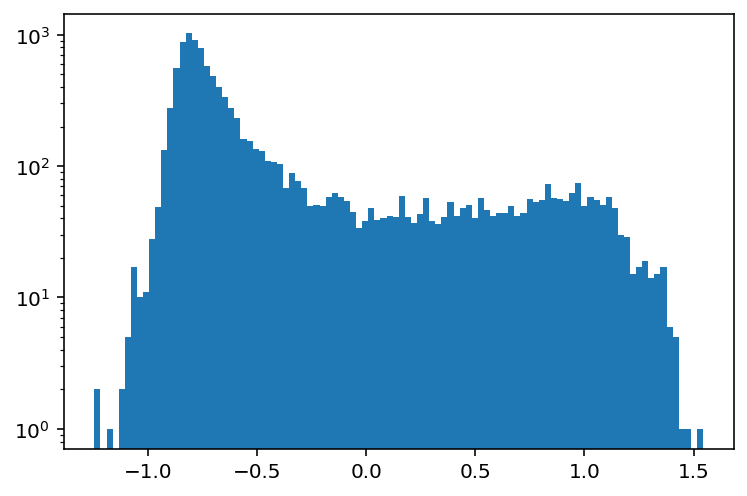

In [18]:
plt.hist(np.log10(dataexp["RNA_exp_average"]),100, log=True);

In [10]:
dataseq = pd.read_excel("review_datasets/Data for Srdjan(2).xlsx", sheet_name=3)

In [38]:
dataseq = dataseq.drop_duplicates()

In [42]:
name = str(dataexp.name[0]).replace("_","-")

In [43]:
dataseq.query(f"name=='{name}'")

,sequence,name
1248,GTTAACAAACAAGGAGAAAACAGTATGAAACACGGAATTAAAGCAC...,gourse-326fold-up-35T->A/33G->T-ECK125136938-7...


In [45]:
dataexp.name = [name.replace("_","-") for name in dataexp.name]

In [46]:
data = dataexp.merge(dataseq.drop_duplicates(), on="name")

In [48]:
data.columns = [c.strip() for c in data.columns] 

In [50]:
data.columns = [c.lower() for c in data.columns]
data['sequence'].apply(lambda xi: xi.find(shinedalgarno)).value_counts()

-1    10898
Name: sequence, dtype: int64

So, no Shine-Delgarno anywhere.

In [51]:
data['promoter length'] = data["sequence"].apply(len)
data["promoter length"].value_counts()

150    10898
Name: promoter length, dtype: int64

In [57]:
lums = data['rna_exp_average'].values
lums = np.log10(lums)

In [59]:
from scipy.stats import median_abs_deviation

In [67]:
mad = median_abs_deviation(lums, scale="normal")
med = np.median(lums)
for _ in range(10):
    ff = lums<med+3*mad
    mad = median_abs_deviation(lums[ff], scale="normal")
    med = np.median(lums[ff])

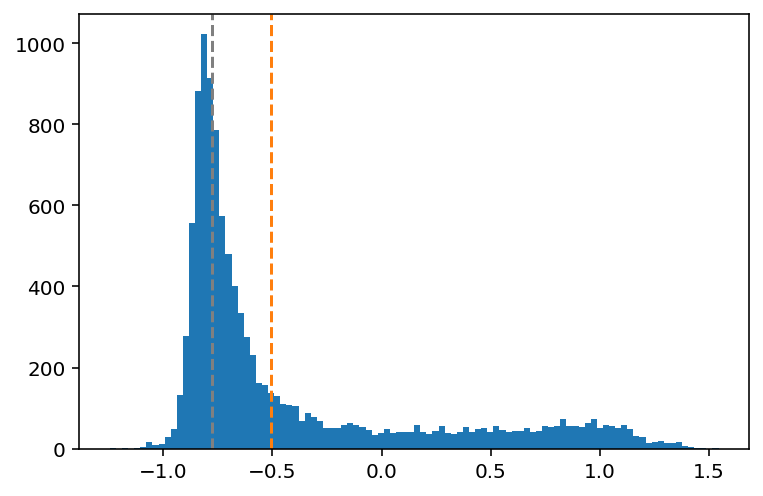

In [69]:
plt.hist(lums,100);
plt.axvline(med, color="grey",ls="--")
plt.axvline(med+3*mad, color="C1",ls="--")

In [70]:
numseq = np.array([[lett2idx[l] for l in s.lower()] for s in data['sequence']],dtype=np.int8)

In [71]:
with open("models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    full_model = pickle.load(f)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [72]:
with open("models/fitted_on_Pr.Pl.36N/model_[0]_stm.dmp", "rb") as f:
    simple_model = pickle.load(f)

In [73]:
with open("models/fitted_on_Pr/model_[4]_stm+flex+cumul+rbs+rc.dmp", "rb") as f:
    full_model_Pr = pickle.load(f)

In [74]:
with open("models/fitted_on_Pr/model_[0]_stm.dmp", "rb") as f:
    simple_model_Pr = pickle.load(f)

In [75]:
from other_datasets_porting import *

In [76]:
tdmodels = {
    "standard": dict2tdm(simple_model),
    "extended": dict2tdm(full_model),
    "standard[Pr]": dict2tdm(simple_model_Pr),
    "extended[Pr]": dict2tdm(full_model_Pr),
}

In [77]:
bricks = {k:tdmodels[k].sequences2bricks(numseq) for k in tdmodels}

In [78]:
{kk: {k: bricks[kk][k].shape for k in bricks[kk]} for kk in bricks}

{'standard': {'frw': (10898, 119, 1)},
 'extended': {'frw': (10898, 119, 5), 'rc': (10898, 119, 5)},
 'standard[Pr]': {'frw': (10898, 119, 1)},
 'extended[Pr]': {'frw': (10898, 119, 5), 'rc': (10898, 119, 5)}}

In [79]:
numseq.shape

(10898, 150)

## no weights

CPU times: user 3min 16s, sys: 2min 15s, total: 5min 32s
Wall time: 5min 32s


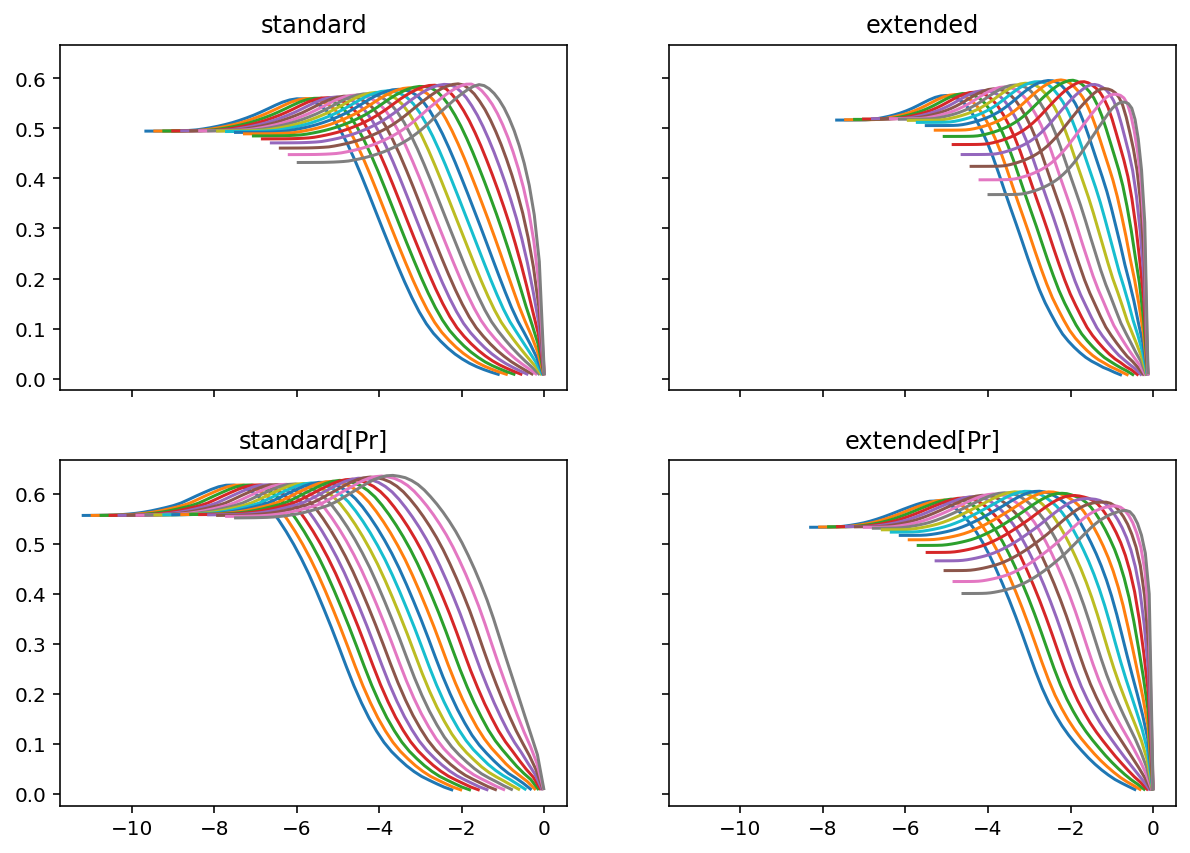

In [80]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax)
    ax.set_title(k)

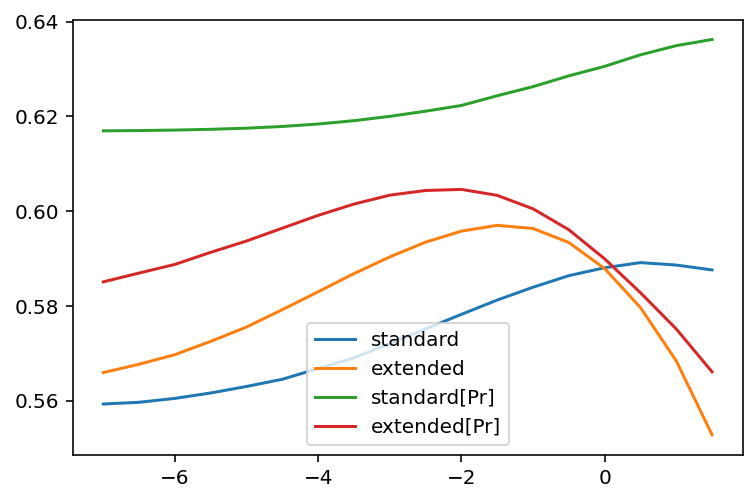

In [81]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

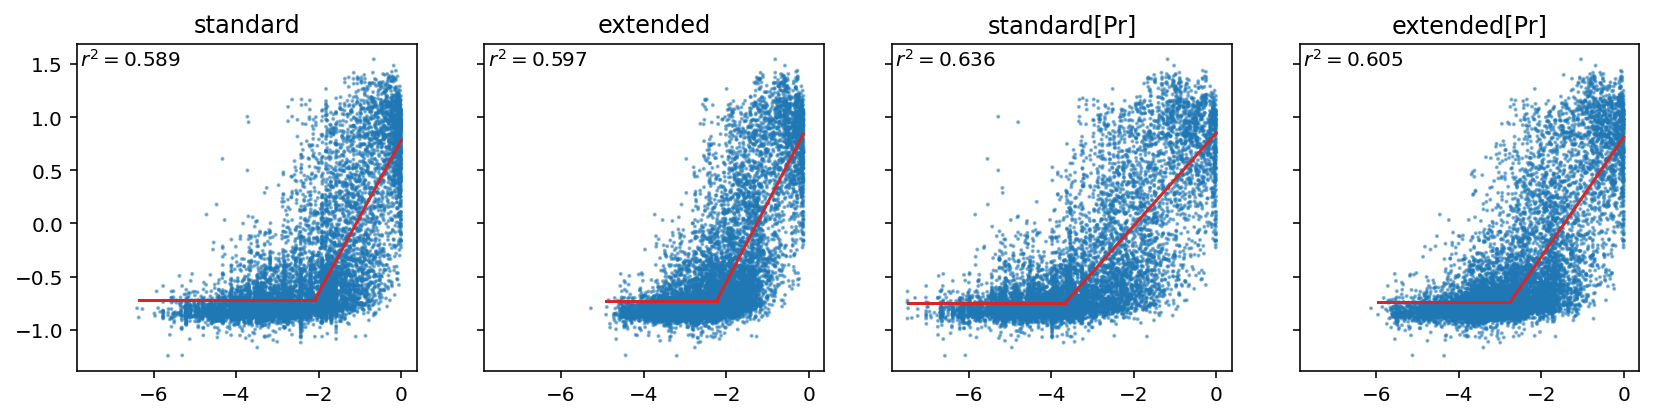

In [82]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax

    )
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## equiweughted

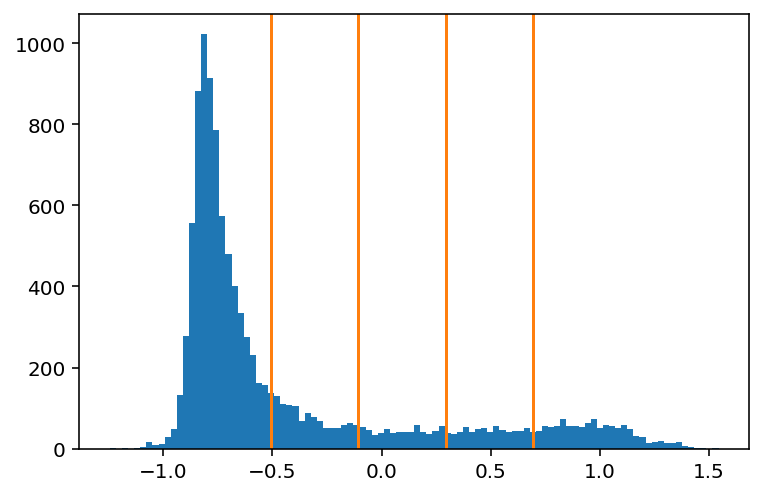

In [83]:
nbins = 5
plt.hist(lums,100);
boundaries = np.linspace(med+3*mad, np.percentile(lums, 90), nbins-1)
for b in boundaries:
    plt.axvline(b,color="C1")
digilums = np.digitize(lums, boundaries)

In [84]:
w = np.ones(len(data))*np.nan

In [85]:
for i in range(nbins):
    w[digilums==i] = 1/(digilums==i).sum()

CPU times: user 3min 18s, sys: 2min 19s, total: 5min 38s
Wall time: 5min 38s


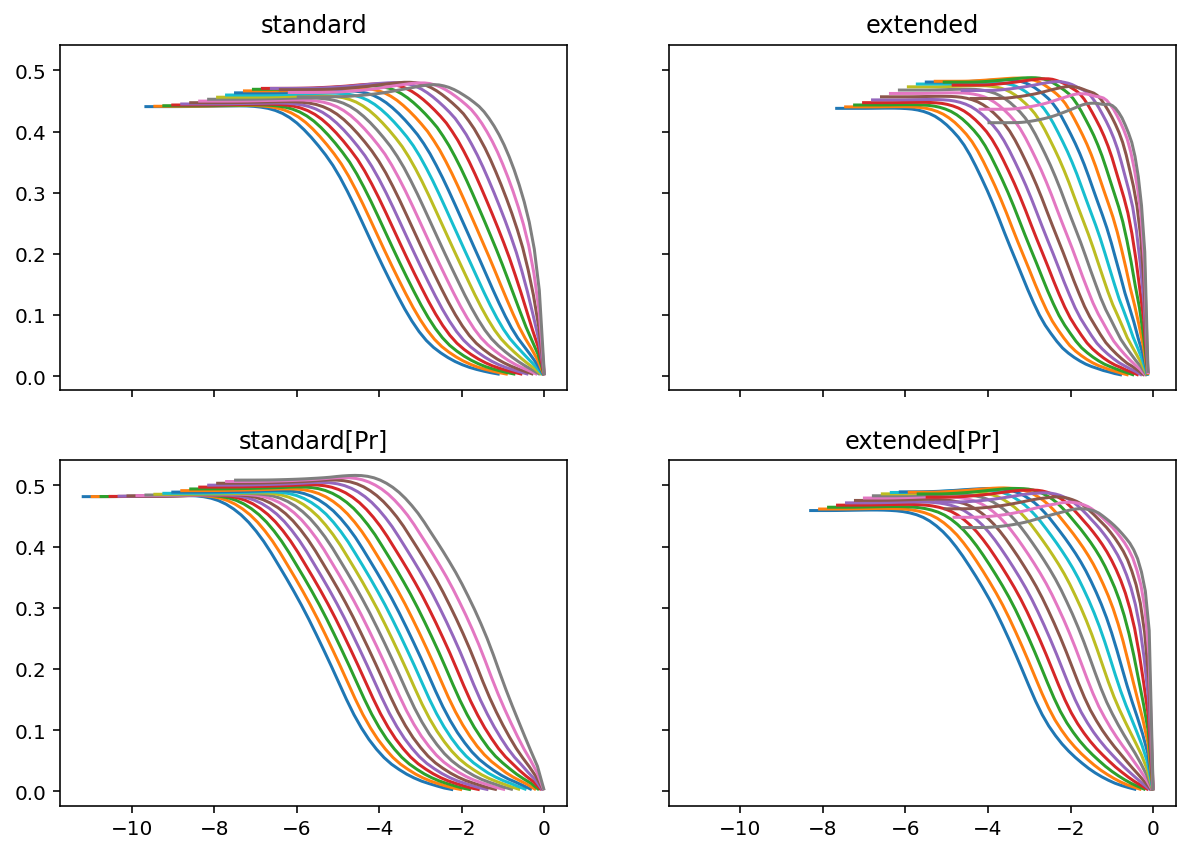

In [86]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax, weights=w)
    ax.set_title(k)

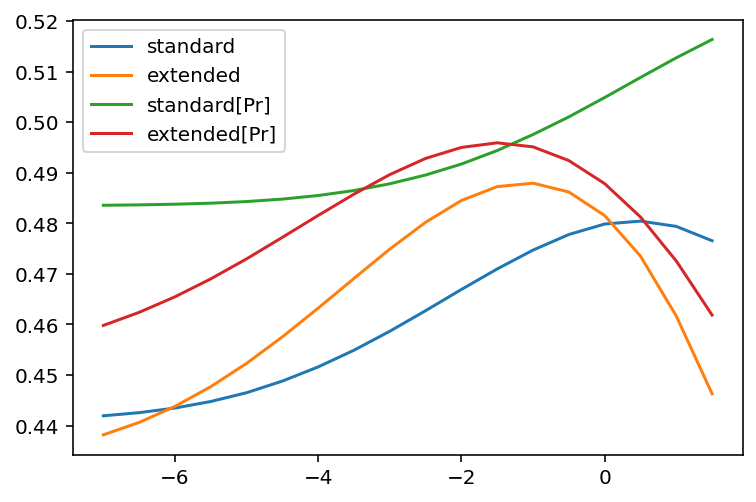

In [87]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

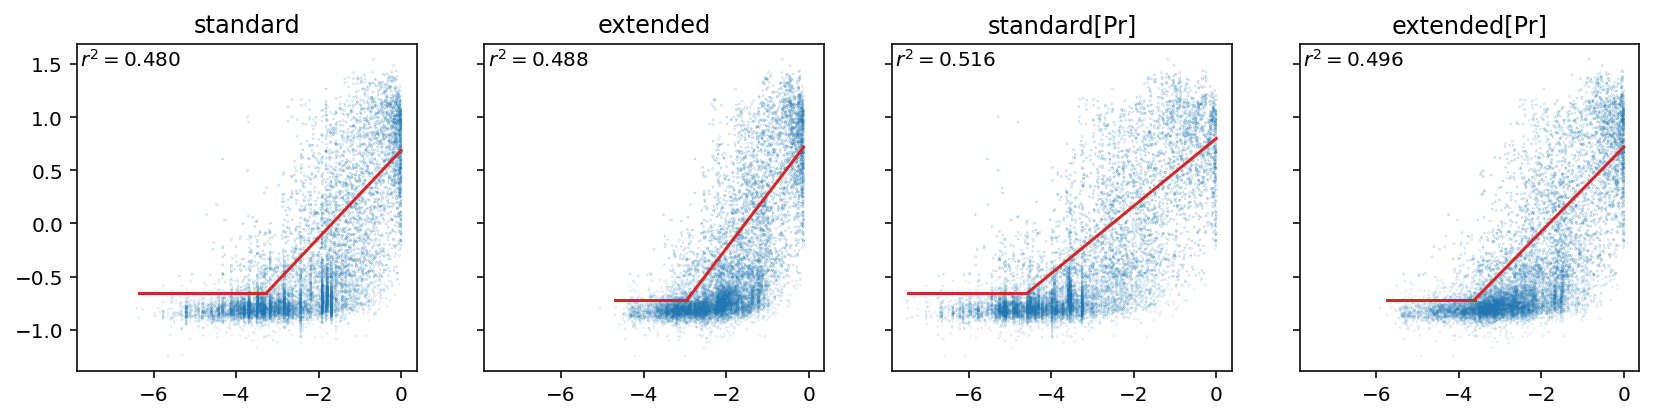

In [88]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    score = evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights = w
    )
    assert score == opt_res[k]["score_opt"]
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## equiweughted, forced to 1

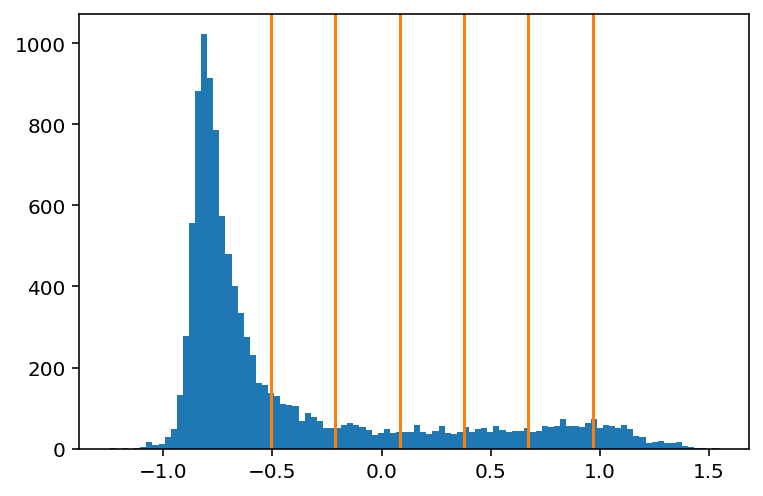

In [128]:
nbins = 7
plt.hist(lums,100);
boundaries = np.linspace(med+3*mad, np.percentile(lums, 95), nbins-1)
for b in boundaries:
    plt.axvline(b,color="C1")
digilums = np.digitize(lums, boundaries)

In [129]:
w = np.ones(len(data))*np.nan

In [130]:
for i in range(nbins):
    w[digilums==i] = 1/(digilums==i).sum()

CPU times: user 2min 50s, sys: 1min 46s, total: 4min 37s
Wall time: 4min 37s


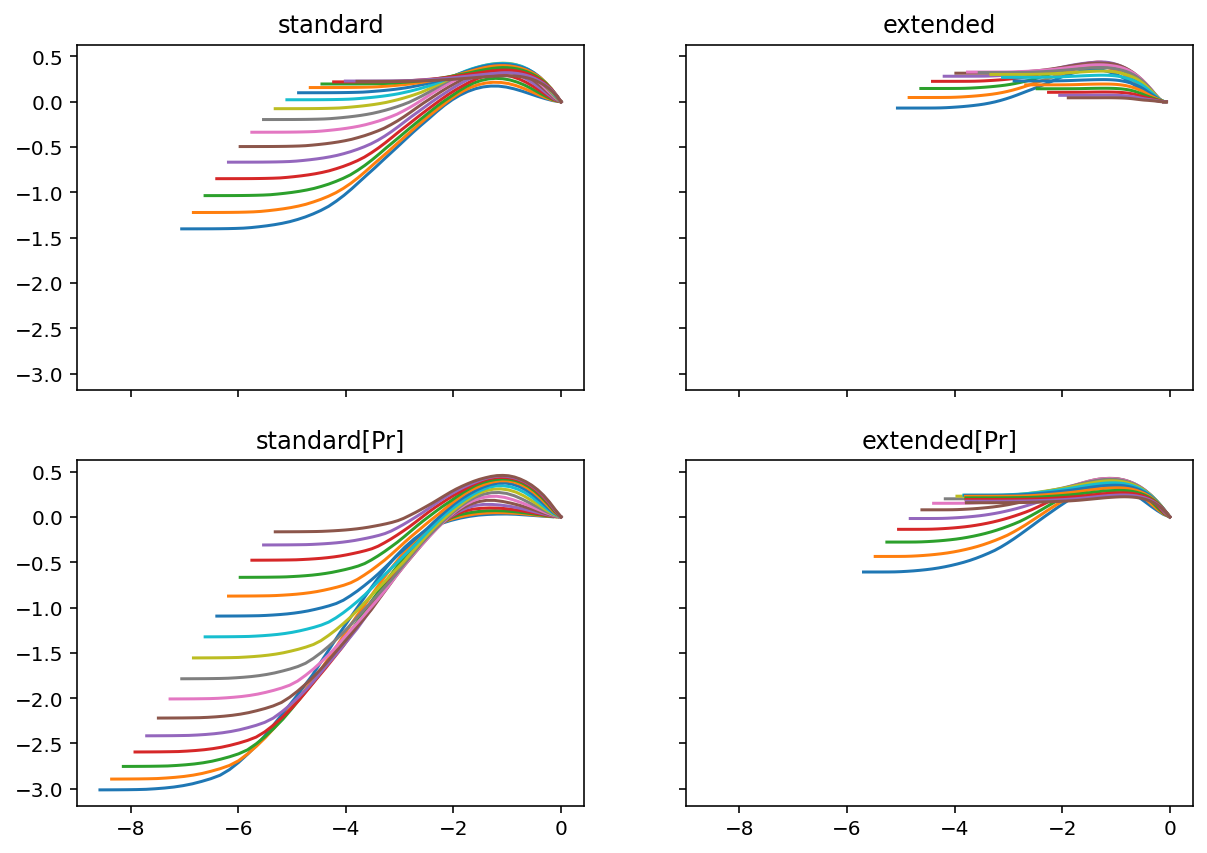

In [187]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-1,7,.5), loglums=lums, ax=ax, weights=w, forceLinear=True)
    ax.set_title(k)

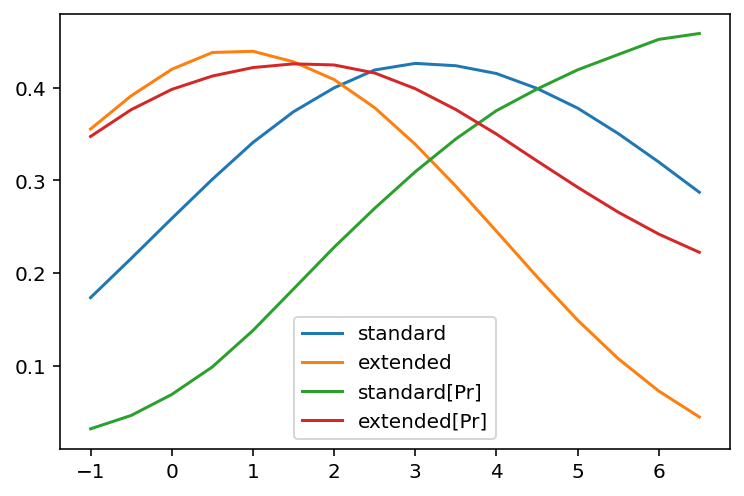

In [188]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

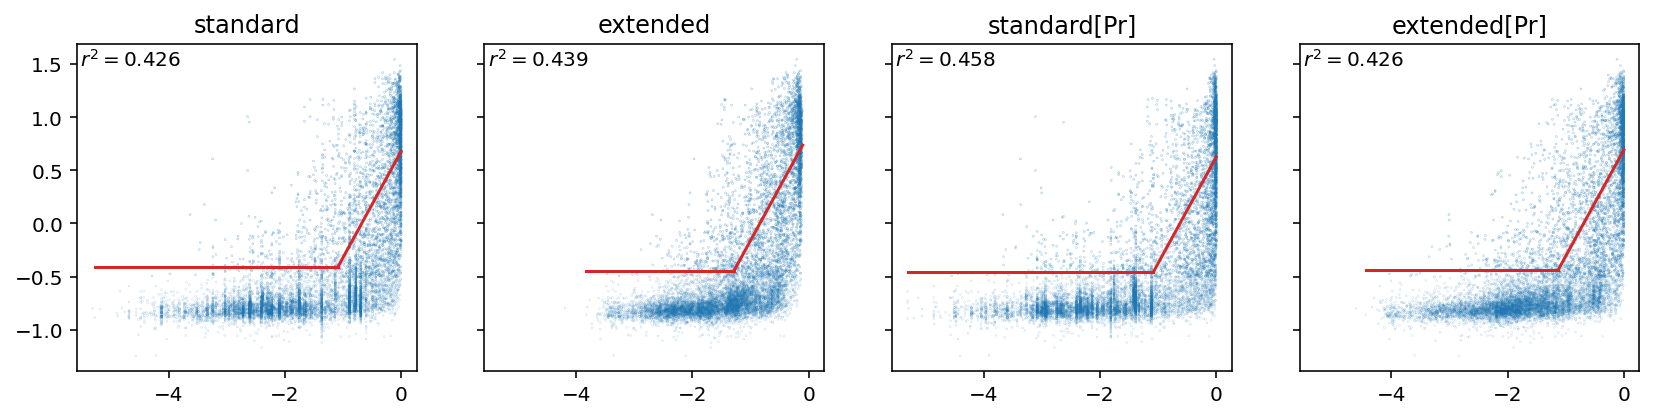

In [189]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    score = evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights = w,
        forceLinear=True
    )
    assert score == opt_res[k]["score_opt"]
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## no weights, forced to 1

In [190]:
del w

CPU times: user 2min 56s, sys: 2min 8s, total: 5min 4s
Wall time: 5min 4s


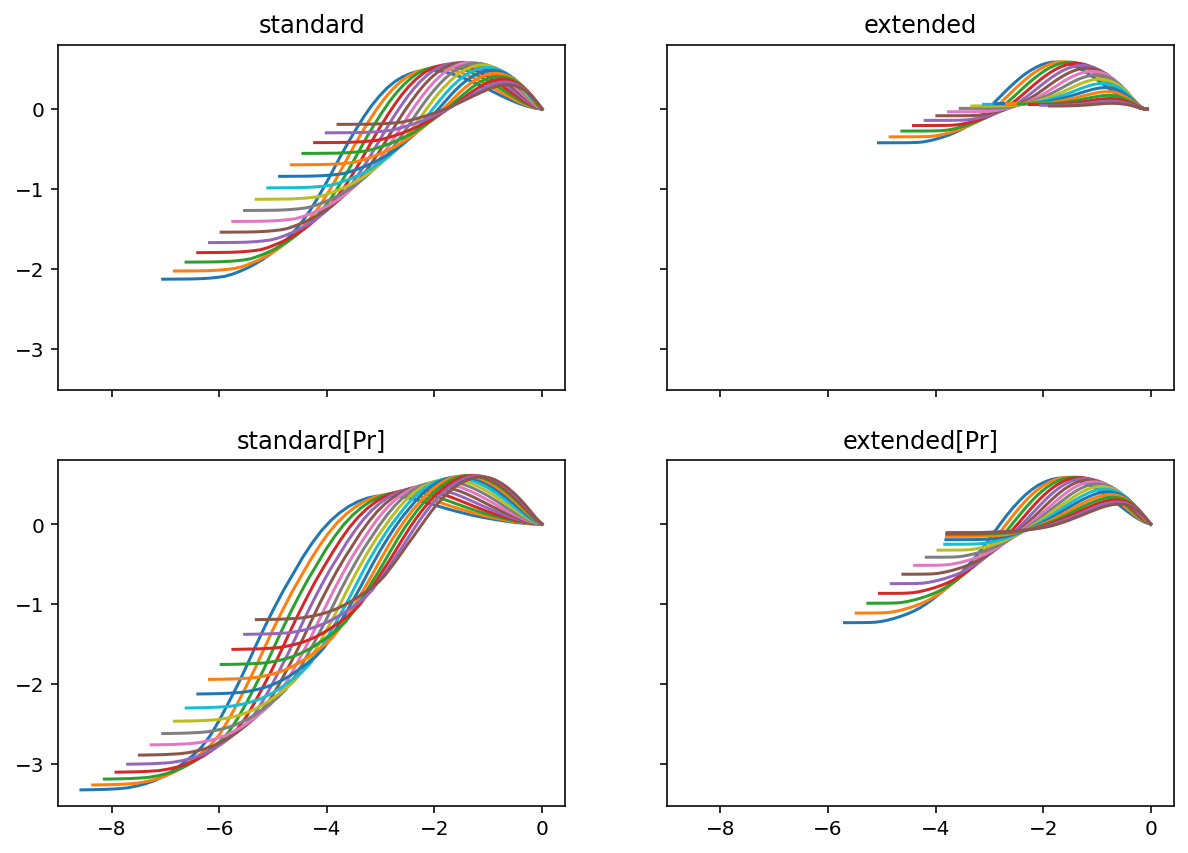

In [191]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-1,7,.5), loglums=lums, ax=ax, forceLinear=True)
    ax.set_title(k)

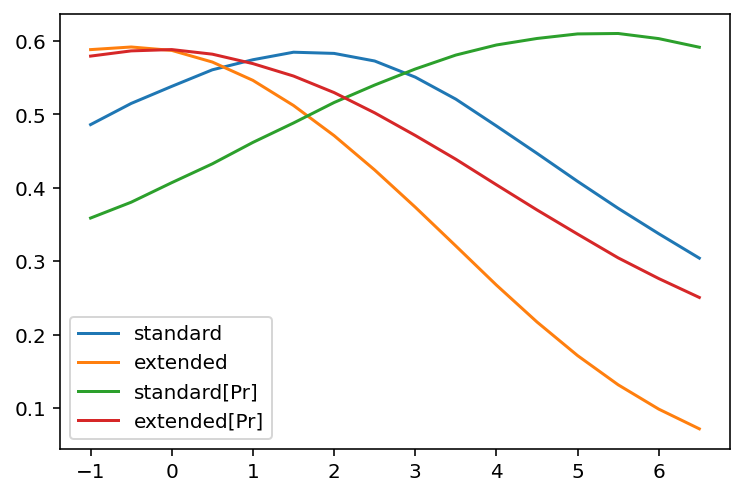

In [192]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

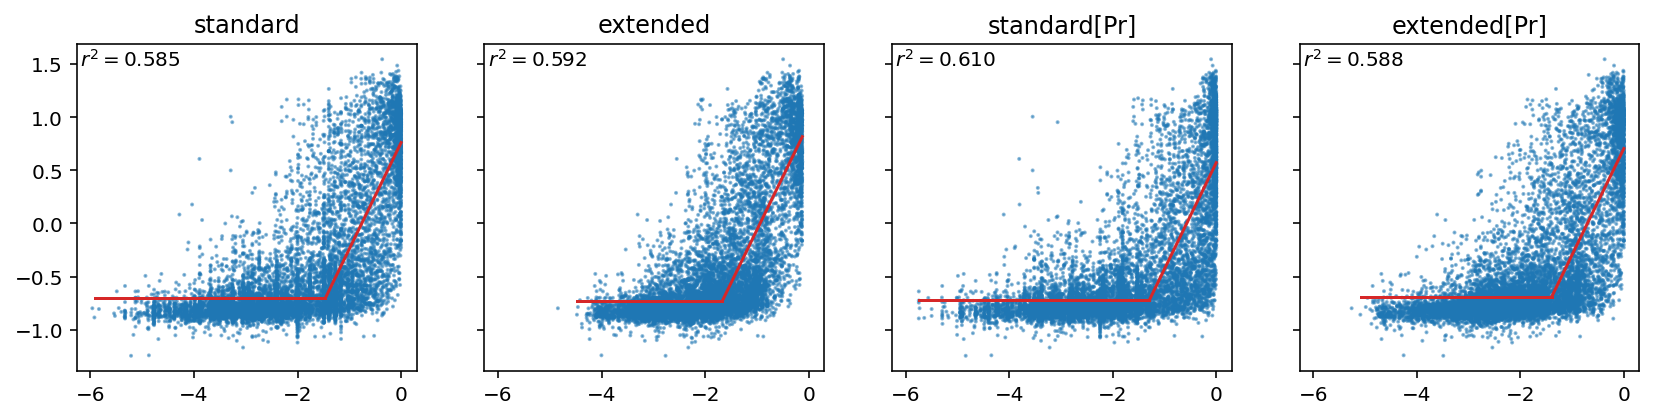

In [193]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    score = evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        forceLinear=True
    )
    assert score == opt_res[k]["score_opt"]
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

In [135]:
m = tdmodels[k]

In [146]:
pons = m.bricks2pons({strand: bricks[k][strand]-(-10) for strand in bricks[k]})

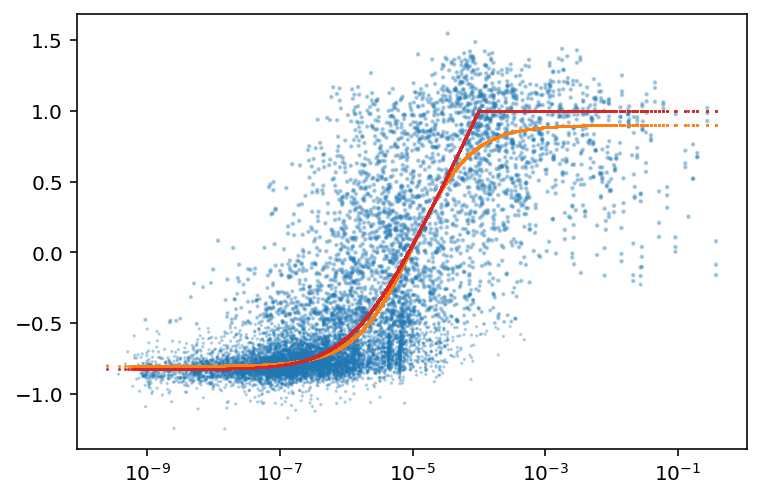

In [184]:
plt.scatter(pons, lums,s=w**.5*40, alpha = .3)
plt.xscale("log")
plt.plot(pons, (1-1/(1+pons/1e-5))*1.7+(-.8),"C1.", ms=1)
plt.plot(pons, np.minimum(1,np.log10(pons*100000+.15)),"C3.", ms=1)

In [97]:
positions = [-br.shape[0]+np.argmin(br.min(-1)) for br in bricks["extended"]["frw"]]

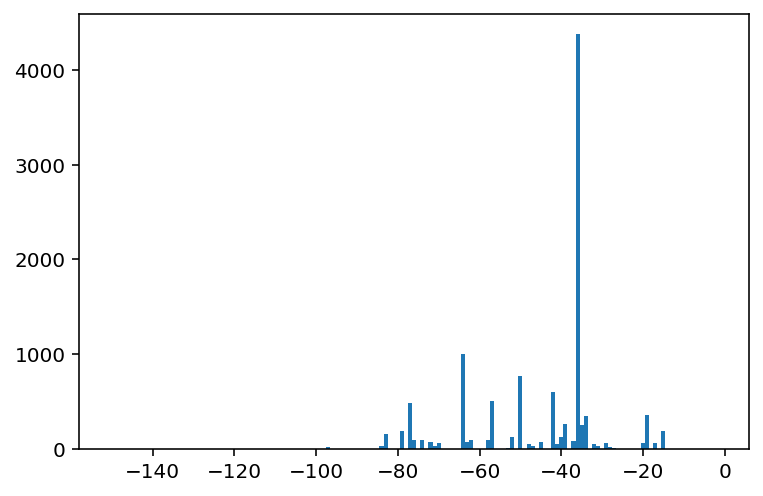

In [98]:
plt.hist(positions, np.arange(-150,0)-.5);